In [ ]:
import math
import numpy as np
import pandas as pd
import pandas_market_calendars as mcal
import matplotlib.pyplot as plt
import yfinance as yf
import QuantLib as ql

from datetime import datetime
from typing import Optional
from scipy.optimize import least_squares

# TODO: ADD PACKAGE VERSIONS TO REQUIREMENTS

# Functions

## Get Option Chains

In [3]:
def market_close_asof(date_local: pd.Timestamp, cal_code: str = "XNYS"):
    """
    Return the most recent market-close timestamp in UTC following a given market calendar.

    Args:
        date_local (pd.Timestamp): Find the most recent market-close as of this local timestamp.
        cal_code (str): Code corresponding to market calendar, e.g. XNYS (NYSE), XNAS (NASDAQ), XLON, XETR.
    
    Returns:
        pd.Timestamp (tz-aware, UTC)
    """
    
    cal = mcal.get_calendar(cal_code)

    # Build a small date window around date of interest to locate prev/next sessions
    date_utc = date_local.tz_convert("UTC")
    start = (date_utc - pd.Timedelta(days = 10)).date()
    end = (date_utc + pd.Timedelta(days = 10)).date()

    # Full schedule with market_open/market_close in calendar's local timezone
    sched = cal.schedule(start_date = start, end_date = end)

    # Convert schedule times to UTC for robust comparisons
    sched_utc = sched.copy()
    sched_utc["market_open_utc"] = sched_utc["market_open"].dt.tz_convert("UTC")
    sched_utc["market_close_utc"] = sched_utc["market_close"].dt.tz_convert("UTC")
    past_closes = sched_utc[sched_utc["market_close_utc"] <= date_utc]["market_close_utc"]

    # Is the market open?
    date_str = date_utc.date().isoformat()
    date_row = sched_utc.loc[date_str] if date_str in sched_utc.index else None

    # Determine the most recent completed close
    if date_row is not None:
        use_today = (date_utc >= date_row["market_close_utc"])
        if use_today:
            return date_row["market_close_utc"]
        else:
            return past_closes.iloc[-1]
    else:
        return past_closes.iloc[-1]

In [4]:
def continuous_rate_from_annual_percent(pct_yield: float) -> float:
    """Convert a quoted annualized percent yield to continuous compounding."""
    y = float(pct_yield) / 100.0
    return np.log(1.0 + max(y, 0.0))

In [5]:
def exp_option_chain(exp_chain: yf.ticker.Ticker, exp: str, df_rows: list, as_of_date, S, r, q) -> list:

    """
    Aggregate option chain for given ticker at specific expiration.

    Args:
        exp_chain (yf.ticker.Ticker):   Option chain object with two DataFrames, one containing all 
                                        the call options data for the selected expiration date and 
                                        the other all the put options data.
        exp (str): Option expiration date as 'YYYY-MM-DD'.
        df_rows (list): List of option chain DataFrames.
        as_of_date (pd.Timestamp): Today's date.
        S (float): Spot price.
        r (float): Risk-free rate.
        q (float): Dividend yield.

    Returns:
        List of option chain DataFrames with those from exp_chain appended.
    """
    for option_type, option_df in [("call", exp_chain.calls), ("put", exp_chain.puts)]:
        
        if option_df is None or option_df.empty:
            continue
        
        tmp = option_df.copy()
        tmp["type"] = option_type
        tmp["expiry"] = pd.to_datetime(exp, utc=True)
        tmp["date"] = as_of_date
        tmp["underlying"] = S
        tmp["rate"] = r
        tmp["div_yield"] = q

        # Parse lastTradeDate and compute quote age (hours)
        if "lastTradeDate" in tmp.columns:
            tmp["lastTradeDate"] = pd.to_datetime(tmp["lastTradeDate"], utc=True, errors="coerce")
            tmp["quote_age_hours"] = (tmp["date"] - tmp["lastTradeDate"]).dt.total_seconds().clip(lower = 0) / 3600.0
        else:
            tmp["lastTradeDate"] = pd.NaT
            tmp["quote_age_hours"] = np.nan

        tmp.rename(columns={"impliedVolatility": "iv_mkt",
                            "lastPrice": "last"}, inplace=True)
        cols = ["contractSymbol", "date", "expiry", "type", "inTheMoney", "strike", "bid", "ask", "last", "iv_mkt", "underlying", 
                "rate", "div_yield", "volume", "openInterest", "lastTradeDate", "quote_age_hours"]
        tmp = tmp[[c for c in cols if c in tmp.columns]]
        df_rows.append(tmp)
    
    return df_rows

In [6]:
def option_chains(ticker: str, market_cal: str, n_exp: int, as_of: str | None = None) -> pd.DataFrame: 
    """
    Get options chain for given ticker.

    Args:
        ticker (str): Stock ticker symbol.
        market_cal (str): Code corresponding to market calendar, e.g. XNYS (NYSE), XNAS (NASDAQ), XLON, XETR.
        n_exp (int): Number of expiries to include.
        as_of (str | None): Date as 'YYYY-MM-DD'. 

    Returns:
        pd.DataFrame: Option chains for all expirations and option types (calls & puts).
    """
    # Market-close timestamp
    if as_of is None:
        # Most recent market-close as of today
        now_utc = pd.Timestamp.now(tz = "UTC")
        as_of = market_close_asof(now_utc, market_cal)
    else:
        # Market-close on given date
        date_utc = pd.Timestamp(as_of).tz_localize("UTC")
        date_utc = date_utc.normalize() + pd.Timedelta(hours = 23, minutes = 59)
        as_of = market_close_asof(date_utc, market_cal)
    
    # Create ticker object
    tk = yf.Ticker(ticker)

    # Available option expiry dates
    opts = tk.options
    if len(opts) == 0:
        raise RuntimeError(f"No option expiries available from yfinance for {ticker} right now.")
    
    # List of n expiries at least a week out
    time_to_expiry = []
    for expiry_date in opts:
        t = int(max(1, (pd.to_datetime(expiry_date, utc = True) - as_of).days))
        if t >= 7:
            time_to_expiry.append(expiry_date)
    expiries = time_to_expiry[:n_exp]

    # Pull 1 day of price history
    hist = tk.history(period = "1d", end = as_of.strftime("%Y-%m-%d"))
    if hist.empty:
        raise RuntimeError(f"No price history returned for {ticker}.")
    
    # Use latest close as spot
    S0 = float(hist["Close"].iloc[-1])

    # Risk-Free Proxy: 13-Week T-Bill
    try:
        irx = yf.Ticker("^IRX").history(period="5d")["Close"].dropna().iloc[-1]
        r_cont = continuous_rate_from_annual_percent(irx)
    except Exception:
        r_cont = 0.02 # fallback
    
    # Dividend Yield Proxy: trailing 365-day dividends / spot
    try:
        divs = tk.dividends
        recent = divs[divs.index >= (as_of - pd.Timedelta(days=365))]
        # Sum the last 365 days of dividends and divide by spot
        q_cont = float(recent.sum() / S0) if not recent.empty else 0.0 # NOT continuous q but proxy for
    except Exception:
        q_cont = 0.0 # fallback
    
    # Aggregate option chains
    rows = []
    for exp in expiries:
        chain = tk.option_chain(exp)
        rows = exp_option_chain(chain, exp, rows, as_of, S0, r_cont, q_cont)    
    df = pd.concat(rows, ignore_index=True)

    # Compute mid price from bid/ask when both exist; otherwise fall back to last price
    df["mid"] = np.where(np.isfinite(df[["bid", "ask"]]).all(axis = 1), 0.5 * (df["bid"] + df["ask"]), df["last"])
    
    # Compute time to expiry in years using Actual/365
    df["T"] = (pd.to_datetime(df["expiry"]) - pd.to_datetime(df["date"])).dt.days.clip(lower = 0).astype(float) / 365.0

    return df

### Clean Data

In [7]:
def clean_data(df: pd.DataFrame, tick: float = 0.01, min_oi: int = 10, age_hours: int = 48) -> pd.DataFrame:
    """
    Clean data and remove invalid & illiquid quotes.
    
    Args:
        df (pd.DataFrame): Option chains data.
        tick (float): Minimum tick, 0.01 default for equity options. 
        min_oi (int): Minimum open interest to identify illiquid quotes.
        age_hours (int): Threshold to mark lastTradeDate as stale.

    Returns:
        pd.DataFrame
    """
    # Remove rows with non-positive prices/strikes or zero time
    df = df[(df["mid"] > 0) & (df["strike"] > 0) & (df["T"] > 0)]

    # Remove rows with missing IVs, bid or ask quotes
    df = df.dropna(subset = ["iv_mkt", "bid", "ask"])

    # Remove rows with obviously broken IVs: negative/zero, or absurdly high (> 500%)
    df.loc[df["iv_mkt"] <= 0, "iv_mkt"] = np.nan
    df.loc[df["iv_mkt"] > 5.0, "iv_mkt"] = np.nan
    df = df.dropna(subset = ["iv_mkt"]).reset_index(drop = True)

    # Identify invalid quotes: ask < bid, negative bid/ask, or zero book
    df["invalid_quote"] = ((df["ask"] < df["bid"]) | 
                           (df["bid"] < 0) | (df["ask"] <= 0) | 
                           ((df["bid"] == 0) & (df["ask"] == 0)))

    # Identify locked quotes with no liquidity: bid = ask & volume = 0 & very low OI
    df["locked_no_liquidity"] = ((df["ask"] - df["bid"] <= tick + 1e-12) & 
                                 (df["volume"].fillna(0) == 0) & 
                                 (df["openInterest"].fillna(0) < min_oi))
    
    # Identify stale quotes ("too old") that were last traded over age_hours since as_of
    df["stale_age"] = ((df["quote_age_hours"] > age_hours))

    # Drop these quotes
    df["drop"] = df[["invalid_quote", "locked_no_liquidity", "stale_age"]].any(axis=1)
    df = df[~df["drop"]]
    df = df.drop(columns=["invalid_quote", "locked_no_liquidity", "stale_age", "drop"])

    return df

In [8]:
def most_liquid_quotes(df: pd.DataFrame, spread_width: float = 0.25) -> pd.DataFrame:
    """
    Only keep the most liquid part of the option chains: ATM +/- 50%.
    
    Args:
        df (pd.DataFrame): Option chains data.
        spread_width (float): Width factor to maintain a reasonable bid–ask spread. 

    Returns:
        pd.DataFrame
    """

    # Forward price
    df["F"] = df["underlying"] * np.exp((df["rate"] - df["div_yield"]) * df["T"])

    # Keep only strikes within +/-50% of forward
    df = df[(df["strike"] >= 0.5 * df["F"]) & (df["strike"] <= 1.5 * df["F"])]

    # Reasonable bid–ask spread
    df = df[((df["ask"] - df["bid"]) / df["mid"]) < spread_width]
    
    return df

## Fit Heston Stochastic Volatility Model (Risk-Neutral Measure)

In [9]:
def build_vanilla_instruments(df: pd.DataFrame, today: ql.Date) -> list:
    """
    Args:
        df (pd.DataFrame): Option chains data.
        today (ql.Date): Evaluation date.

    Returns:
        list of ql.VanillaOption objects corresponding to options available in chains.
    """

    options = []
    for _, df_row in df.iterrows():
        
        # Maturity
        T_days = int(max(1, (pd.to_datetime(df_row["expiry"]) - pd.to_datetime(df_row["date"])).days))
        maturity = today + T_days  # or cal.advance(today, T_days, ql.Days)
        exercise = ql.EuropeanExercise(maturity)

        # Payoff
        payoff = ql.PlainVanillaPayoff(ql.Option.Call if str(df_row["type"]).lower().startswith('c') else ql.Option.Put, float(df_row["strike"]))
        
        # Option Specification
        opt = ql.VanillaOption(payoff, exercise)
        options.append(opt)
    
    return options

In [37]:
def bs_price_vega(df: pd.DataFrame, options: list, S_q: ql.QuoteHandle,
                  r_ts: ql.YieldTermStructureHandle, q_ts: ql.YieldTermStructureHandle) -> pd.DataFrame:
    """
    Compute the Black-Scholes-Merton option price & vega for each quote in the options chain.
    
    Args:
        df (pd.DataFrame): Option chains data.
        options (list): List of ql.VanillaOption objects corresponding to option chains.
        S_q (ql.QuoteHandle): Spot quote.
        r_ts (ql.YieldTermStructureHandle): Risk-free curve.
        q_ts (ql.YieldTermStructureHandle): Dividend curve.
    
    Returns:
        pd.DataFrame with the option chains data and two new columns containing the Black-Scholes-Merton 
        option price ("bs_price") and corresponding vega ("vega") for each option.
    """

    bs_prices = []
    bs_vegas  = []

    df = df.reset_index()
    for i, df_row in df.iterrows():

        # Build Volatility Curve
        sigma = float(df_row["iv_mkt"])
        vol_curve = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(0, ql.TARGET(), sigma, ql.Actual365Fixed()))

        # Build Black-Scholes-Merton process
        process = ql.BlackScholesMertonProcess(S_q, q_ts, r_ts, vol_curve)
        
        # Corresponding VanillaOption object
        option = options[i]

        # Black-Scholes analytic pricing engine
        engine = ql.AnalyticEuropeanEngine(process)
        option.setPricingEngine(engine)

        # Compute option price & vega
        bs_prices.append(option.NPV())
        bs_vegas.append(option.vega())

    df["bs_price"] = bs_prices
    df["vega"] = bs_vegas

    return df

### Calibration Weighting

Since not all quotes are equally trustworthy (e.g. options with tight bid-ask spreads are more reliable than illliquid ones, far OTM/ITM options may be more noisy than near-ATM options), we apply the following per-point weights to ensure that less reliable quotes don't overpower or distort the model calibration: 

$$w_i = w_i^{\text{IV}} \cdot w_i^{\text{wing}} = \frac{\exp{(-\lambda \left| k_i \right|)}}{(\Delta \sigma_i)^2}$$

**Inverse-IV-Variance Weights:** $\hspace{5pt} w_i^{\text{IV}} = \frac{1}{(\Delta \sigma_i)^2}$, $\hspace{5pt} \Delta \sigma_i \approx \frac{(\text{bid} - \text{ask})/2}{\text{vega}}$

* Tight Spread $\to$ Low Variance $\to$ High Weight
* Wide Spread $\to$ High Variance $\to$ Low Weight

**Wing Damping Weights:** $\hspace{5pt} w_i^{\text{wing}} = \exp{(-\lambda \left| k_i \right|)}$, $\hspace{5pt} k = \ln(K/F)$

* Down-weight options far from forward, which usually have noisy quotes and very low vega.

**Per-Expiry Normalization:** $\hspace{5pt} \Sigma_{j \in \text{expiry}}w_j^{\text{norm}} = 1$


In [11]:
def inverse_variance_weighting(bid: float, ask: float, S: float, K: float, T: float, r: float, q: float, iv: float, vega: float,
                               min_tick: float = 0.01, min_half_spread_iv: float = 0.0025, min_vega: float = 1e-5) -> float:
    """
    Give more weight to options with tight bid-ask spreads (as they are more reliable) in model calibration. 
    Convert each bid–ask spread in price space into a half-spread in IV space & assign weights using:
    w = 1/(spread^2).

    Args:
        bid (float): Bid quote.
        ask (float): Ask quote.
        S (float): Spot price.
        K (float): Strike price.
        T (float): Time to expiration.
        r (float): Risk-free rate.
        q (float): Dividend yield.
        iv (float): Implied volatility.
        vega (float): Vega of option.
        min_tick (float): Tick floor for bid-ask spread.
        min_half_spread_iv (float): Floor for IV half-spread.
        min_vega (float): Vega threshold.
    
    Returns:
        float weight. 
    """

    # Validate
    if not np.isfinite(bid) or not np.isfinite(ask) or ask <= bid or T <= 0 or iv <= 0:
        return np.nan
    
    # Price half-spread with tick floor
    half_spread_price = 0.5 * max(ask - bid, min_tick)

    # Convert price half-spread to IV half-spread
    if vega < min_vega:
        return np.nan
    half_spread_iv = half_spread_price / vega
    half_spread_iv = max(half_spread_iv, min_half_spread_iv)
    
    # Inverse-variance weight
    return 1.0 / (half_spread_iv ** 2)

In [12]:
def wing_damping_weighting(K: float, F: float, wing_lambda: float = 0.5) -> float:
    """
    Down-weight options far from forward to focus calibration on 'core' region where vol smile is anchored using:
    w = exp(-lambda * |k|).
    
    Args:
        K (float): Strike price.
        F (float): Forward price.
        wing_lambda (float): Strength of exponential damping.
    
    Returns:
        float weight.
    """

    # Log-moneyness
    k = np.log(np.maximum(1e-12, (K / np.maximum(1e-12, F))))
    
    # Wing damping: as price moves away from strike, weight decays exponentially
    return np.exp(-wing_lambda * np.abs(k))

In [13]:
def calibration_weighting(df: pd.DataFrame, lambda_wing: float) -> pd.DataFrame:
    """
    Compute weight for each option that indicates how 'trustworthy' the quote is and how much it should 
    influence the volatility surface model calibration. Weights are normalized per expiry so one 
    maturity doesn't overwhelm model fit.

    Args:
        df (pd.DataFrame): Option chains data.
        wing_lambda (float): Rate of exponential decay in wing damping.

    Returns:
        pd.DataFrame containg option chains data with weight columns appended.
    """
    w_iv_list = []
    w_wing_list = []
    for _, df_row in df.iterrows():
        
        bid_w = df_row["bid"]
        ask_w = df_row["ask"]
        S_w = df_row["underlying"]
        K_w = df_row["strike"]
        T_w = df_row["T"]
        r_w = df_row["rate"]
        q_w = df_row["div_yield"]
        iv_w = df_row["iv_mkt"]
        vega_w = df_row["vega"]
        F_w = df_row["F"]
        
        # Inverse-IV-variance weight
        iv_weight = inverse_variance_weighting(bid_w, ask_w, S_w, K_w, T_w, r_w, q_w, iv_w, vega_w)
        w_iv_list.append(iv_weight)

        # Wing damping weight
        wd_weight = wing_damping_weighting(K_w, F_w, lambda_wing)
        w_wing_list.append(wd_weight)

    df["w_iv"] = w_iv_list
    df["w_wing"] = w_wing_list
    df["w"] = df["w_iv"] * df["w_wing"]
    df = df.dropna(subset = ["w_iv", "w_wing", "w"]).reset_index(drop = True)

    # Normalize Per Expiry
    df["w_norm"] = 0.0
    for exp, idx in df.groupby("expiry").groups.items():
        idx = list(idx)
        w_sum = df.loc[idx, "w"].sum()
        df.loc[idx, "w_norm"] = df.loc[idx, "w"] / (w_sum if w_sum > 0 else 1.0)
    
    return df

### Fit Model

In [17]:
def make_engine(S_q: ql.QuoteHandle, r_ts: ql.YieldTermStructureHandle, q_ts: ql.YieldTermStructureHandle, 
                kappa: float, theta: float, sigma: float, rho: float, v0: float) -> tuple:
    """
    Create a stochastic Heston model and pricing engine for asset & variance evolution under the risk-neutral 
    measure, given a set of parameters.

    Args:
        S_q (ql.QuoteHandle): Spot quote.
        r_ts (ql.YieldTermStructureHandle): Risk-free curve.
        q_ts (ql.YieldTermStructureHandle): Dividend curve.
        kappa (float): Mean reversion speed of variance.
        theta (float): Long-run variance level.
        sigma (float): Volatility of variance (vol of vol).
        rho (float): Correlation between asset returns and variance shocks.
        v0 (float): Initial variance.
        
    Returns:
        tuple containing the HestonModel and the AnalyticHestonEngine.
    """
    process = ql.HestonProcess(r_ts, q_ts, S_q, float(v0), float(kappa), float(theta), float(sigma), float(rho))
    model   = ql.HestonModel(process)
    engine  = ql.AnalyticHestonEngine(model)
    return model, engine

In [ ]:
def fit_heston_ls(df: pd.DataFrame, options: list, 
                  S_q: ql.QuoteHandle, r_ts: ql.YieldTermStructureHandle, q_ts: ql.YieldTermStructureHandle) -> tuple:
    """
    Calibrates Heston model to option chains by finding the parameter vector that minimizes the weighted sum 
    of squared price errors via non-linear least squares.
    
    Args:
        df (pd.DataFrame): Option chains data.
        options (list): List of ql.VanillaOption objects corresponding to option chains. 
        S_q (ql.QuoteHandle): Spot quote.
        r_ts (ql.YieldTermStructureHandle): Risk-free curve.
        q_ts (ql.YieldTermStructureHandle): Dividend curve.
    
    Returns:
        tuple containing the fitted Heston parameters: kappa, theta, sigma, rho, v0.
    """

    prices_mkt = df["mid"].to_numpy(float)
    weights = df["w_norm"].to_numpy(float)

    # Residual function for least-squares
    def resid(params: list) -> list:
        
        kappa, theta, sigma, rho, v0 = params

        # Basic bounds inside residual (keeps optimizer sane)
        if not (0.0 < kappa <= 15.0 and 1e-6 <= theta <= 1.0 and 0.05 <= sigma <= 2.0 and -0.999 < rho < 0.0 and 1e-6 <= v0 <= 1.0):
            return np.ones_like(prices_mkt) * 1e6
        
        # Create AnalyticHestonEngine for params
        _, engine = make_engine(S_q, r_ts, q_ts, kappa, theta, sigma, rho, v0)

        # Set engine & get model prices
        model_prices = np.empty_like(prices_mkt)
        for i, opt in enumerate(options):
            opt.setPricingEngine(engine)
            model_prices[i] = float(opt.NPV())
        
        # Weighted residuals (absolute price)
        weighted_resid = np.sqrt(weights) * (model_prices - prices_mkt)
        return weighted_resid
    
    # Initial seeds
    atm_iv  = float(df["iv_mkt"].median())
    v0_seed = max(1e-4, atm_iv**2)
    x0 = np.array([2.0,  max(1e-4, (atm_iv*1.1)**2), 0.5, -0.5, v0_seed])

    # Parameter bounds
    lb = np.array([0.05, 1e-6, 0.05, -0.999, 1e-6])
    ub = np.array([15.0, 1.0,  2.00, -1e-3,  1.0])

    # Minimize weighted sum of squared price errors via least squares
    res = least_squares(resid, x0, bounds = (lb, ub), xtol = 1e-8, ftol = 1e-8, gtol = 1e-8, max_nfev = 400)

    # Parameters: kappa, theta, sigma, rho, v0
    return res.x

In [20]:
def rmse_price(df: pd.DataFrame, options: list, engine: ql.AnalyticHestonEngine) -> float:
    """
    Evaluate the root mean square price error between market price and model price.
    
    Args:
        df (pd.DataFrame): Option chains data.
        options (list): List of ql.VanillaOption objects corresponding to option chains. 
        engine (ql.AnalyticHestonEngine): Calibrated Heston pricing engine.
    
    Returns:
        floar root mean square price error.
    """
    
    heston_prices = []
    for opt in options:
        opt.setPricingEngine(engine)
        heston_prices.append(float(opt.NPV()))
    heston_prices = np.array(heston_prices)
    prices_mkt = df["mid"].to_numpy(float)
    return float(np.sqrt(np.nanmean((heston_prices - prices_mkt)**2)))

### Compute Implied Volatility

In [39]:
def heston_iv(df: pd.DataFrame, engine: ql.AnalyticHestonEngine, today: ql.Date, 
              S_q: ql.QuoteHandle, r_ts: ql.YieldTermStructureHandle, q_ts: ql.YieldTermStructureHandle) -> pd.DataFrame:
    """
    Compute Heston-derived implied volatility.

    Args:
        df (pd.DataFrame): Option chains data.
        engine (ql.AnalyticHestonEngine): Calibrated Heston pricing engine.
        today (ql.Date): Evaluation date.
        S_q (ql.QuoteHandle): Spot quote.
        r_ts (ql.YieldTermStructureHandle): Risk-free curve.
        q_ts (ql.YieldTermStructureHandle): Dividend curve.
        
    Returns:
        pd.DataFrame containing option chains data with the computed implied volatility in the "iv_heston" column.
    """

    # Build a flat BSM volatility curve with arbitrary seed (doesn't matter)
    vol_seed = ql.BlackConstantVol(today, ql.NullCalendar(), 0.20, ql.Actual365Fixed())
    vol_ts_seed = ql.BlackVolTermStructureHandle(vol_seed)
    bsm_process = ql.BlackScholesMertonProcess(S_q, q_ts, r_ts, vol_ts_seed)

    heston_ivs = []
    for _, df_row in df.iterrows():
        # Maturity
        T_days = int(max(1, (pd.to_datetime(df_row["expiry"]) - pd.to_datetime(df_row["date"])).days))
        maturity = today + T_days
        exercise = ql.EuropeanExercise(maturity)

        # Create option
        option_type = ql.Option.Call if str(df_row["type"]).lower().startswith('c') else ql.Option.Put
        option = ql.VanillaOption(ql.PlainVanillaPayoff(option_type, float(df_row["strike"])), exercise)

        # Price option using calibrated Heston model
        option.setPricingEngine(engine)
        price_model = float(option.NPV())

        # Compute implied volatility
        iv = option.impliedVolatility(price_model, bsm_process, 1e-8, 100, 1e-6, 6.0)
        heston_ivs.append(iv)

    df["iv_heston"] = heston_ivs
    return df

# Run

In [21]:
# Inputs
TICKER      = "SPY"
MARKET_CAL  = "XNYS"        # Code corresponding to market calendar (e.g. XNYS (NYSE), XNAS (NASDAQ), XLON, XETR)
N_EXP       = 10            # Number of expiries to pull
AS_OF       = None          # Set to 'YYYY-MM-DD' to override (e.g., "2025-10-10")

# Parameters
TICK        = 0.01          # Equity options minimum tick
MIN_OI      = 10            # Minimum openInterest
AGE_HOURS   = 48            # Threshold to mark lastTradeDate as stale
LAMBDA_WING = 0.5

In [22]:
chains = option_chains(TICKER, MARKET_CAL, N_EXP, AS_OF)
chains_clean = clean_data(chains, TICK, MIN_OI, AGE_HOURS)
chains_clean = most_liquid_quotes(chains_clean)

# Pre-build QL objects that don't change
date = pd.to_datetime(chains_clean["date"].iloc[0])
today = ql.Date(date.day, int(date.month), int(date.year))
ql.Settings.instance().evaluationDate = today
cal = ql.UnitedStates(ql.UnitedStates.NYSE)

S0 = float(chains_clean["underlying"].iloc[0])
r = float(chains_clean["rate"].iloc[0])
q = float(chains_clean["div_yield"].iloc[0])

S_quote = ql.QuoteHandle(ql.SimpleQuote(S0))
r_curve = ql.YieldTermStructureHandle(ql.FlatForward(0, ql.TARGET(), r, ql.Actual365Fixed()))
q_curve = ql.YieldTermStructureHandle(ql.FlatForward(0, ql.TARGET(), q, ql.Actual365Fixed()))

## All Expiries

### Calls Only

In [50]:
call_chains = chains_clean[chains_clean['type'] == 'call']

calls_list = build_vanilla_instruments(call_chains, today)
call_chains = bs_price_vega(call_chains, calls_list, S_quote, r_curve, q_curve)
call_chains = calibration_weighting(call_chains, LAMBDA_WING)

kappa, theta, sigma, rho, v0 = fit_heston_ls(call_chains, calls_list, S_quote, r_curve, q_curve)
fitted_model, calibrated_engine = make_engine(S_quote, r_curve, q_curve, kappa, theta, sigma, rho, v0)
rmse = rmse_price(call_chains, calls_list, calibrated_engine)
call_chains = heston_iv(call_chains, calibrated_engine, today, S_quote, r_curve, q_curve)

print("Calibrated Heston params:")
print(f"  kappa = {float(kappa):.8f}")
print(f"  theta = {float(theta):.8f}")
print(f"  sigma = {float(sigma):.8f}")
print(f"  rho   = {float(rho):.8f}")
print(f"  v0    = {float(v0):.8f}")
print(f"Price RMSE: {float(rmse):.8f} (Mean Option Price: {float(np.nanmean(call_chains["mid"])):.8f})")

Calibrated Heston params:
  kappa = 9.93165289
  theta = 0.04152446
  sigma = 1.76470445
  rho   = -0.61471760
  v0    = 0.02615719
Price RMSE: 0.47047943 (Mean Option Price: 45.56943396)


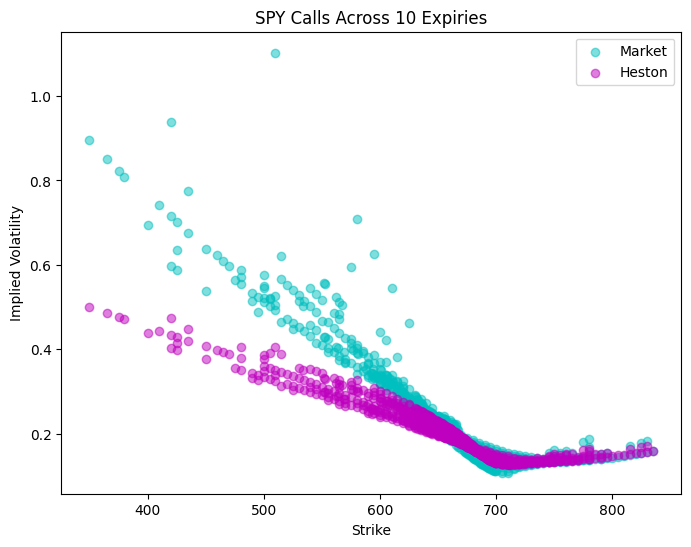

In [51]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(call_chains['strike'], call_chains['iv_mkt'], color = 'c', alpha = 0.5, label = 'Market')
ax.scatter(call_chains['strike'], call_chains['iv_heston'], color = 'm', alpha=0.5, label = 'Heston')
ax.set_xlabel("Strike")
ax.set_ylabel("Implied Volatility")
ax.set_title(f"{TICKER} Calls Across {N_EXP} Expiries")
plt.legend()
plt.show()

### Puts Only

In [52]:
put_chains = chains_clean[chains_clean['type'] == 'put']

puts_list = build_vanilla_instruments(put_chains, today)
put_chains = bs_price_vega(put_chains, puts_list, S_quote, r_curve, q_curve)
put_chains = calibration_weighting(put_chains, LAMBDA_WING)

kappa, theta, sigma, rho, v0 = fit_heston_ls(put_chains, puts_list, S_quote, r_curve, q_curve)
fitted_model, calibrated_engine = make_engine(S_quote, r_curve, q_curve, kappa, theta, sigma, rho, v0)
rmse = rmse_price(put_chains, puts_list, calibrated_engine)
put_chains = heston_iv(put_chains, calibrated_engine, today, S_quote, r_curve, q_curve)

print("Calibrated Heston params:")
print(f"  kappa = {float(kappa):.8f}")
print(f"  theta = {float(theta):.8f}")
print(f"  sigma = {float(sigma):.8f}")
print(f"  rho   = {float(rho):.8f}")
print(f"  v0    = {float(v0):.8f}")
print(f"Price RMSE: {float(rmse):.8f} (Mean Option Price: {float(np.nanmean(put_chains["mid"])):.8f})")

Calibrated Heston params:
  kappa = 4.04299609
  theta = 0.06925889
  sigma = 2.00000000
  rho   = -0.29837628
  v0    = 0.02539873
Price RMSE: 0.22343899 (Mean Option Price: 4.89941774)


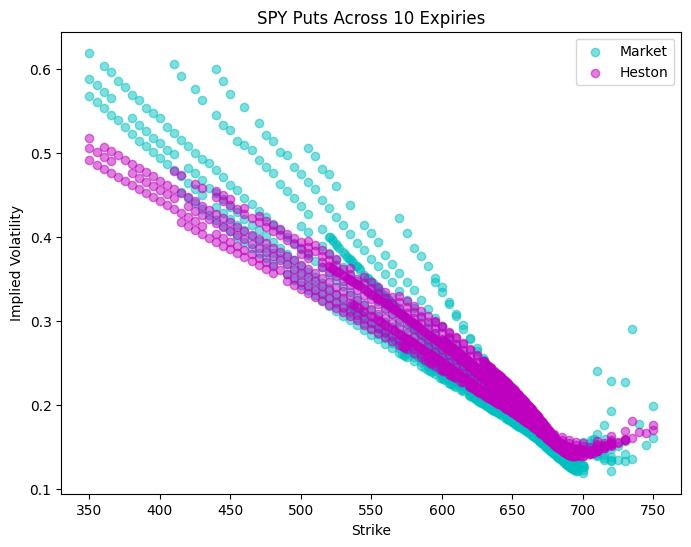

In [53]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(put_chains['strike'], put_chains['iv_mkt'], color = 'c', alpha = 0.5, label = 'Market')
ax.scatter(put_chains['strike'], put_chains['iv_heston'], color = 'm', alpha=0.5, label = 'Heston')
ax.set_xlabel("Strike")
ax.set_ylabel("Implied Volatility")
ax.set_title(f"{TICKER} Puts Across {N_EXP} Expiries")
plt.legend()
plt.show()

### All Options

In [54]:
all_option_chains = chains_clean.copy()

all_options_list = build_vanilla_instruments(all_option_chains, today)
all_option_chains = bs_price_vega(all_option_chains, all_options_list, S_quote, r_curve, q_curve)
all_option_chains = calibration_weighting(all_option_chains, LAMBDA_WING)

kappa, theta, sigma, rho, v0 = fit_heston_ls(all_option_chains, all_options_list, S_quote, r_curve, q_curve)
fitted_model, calibrated_engine = make_engine(S_quote, r_curve, q_curve, kappa, theta, sigma, rho, v0)
rmse = rmse_price(all_option_chains, all_options_list, calibrated_engine)
all_option_chains = heston_iv(all_option_chains, calibrated_engine, today, S_quote, r_curve, q_curve)

print("Calibrated Heston params:")
print(f"  kappa = {float(kappa):.8f}")
print(f"  theta = {float(theta):.8f}")
print(f"  sigma = {float(sigma):.8f}")
print(f"  rho   = {float(rho):.8f}")
print(f"  v0    = {float(v0):.8f}")
print(f"Price RMSE: {float(rmse):.8f} (Mean Option Price: {float(np.nanmean(all_option_chains["mid"])):.8f})")

Calibrated Heston params:
  kappa = 7.68831895
  theta = 0.04394571
  sigma = 1.61474549
  rho   = -0.56234876
  v0    = 0.02461388
Price RMSE: 0.42429631 (Mean Option Price: 22.76893782)


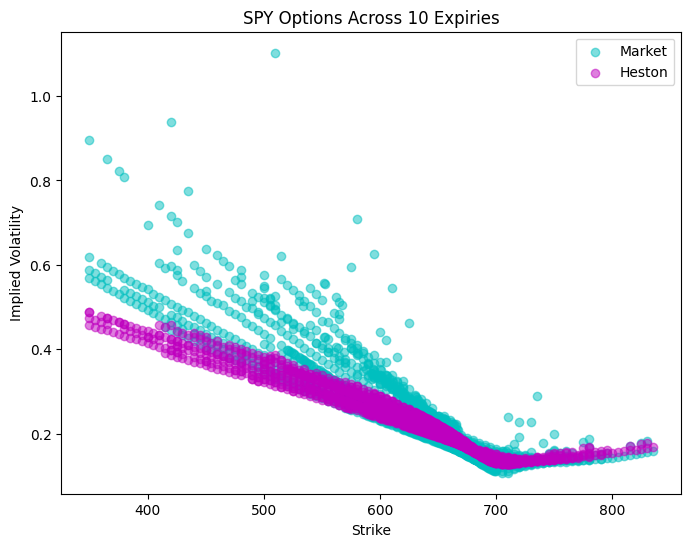

In [55]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(all_option_chains['strike'], all_option_chains['iv_mkt'], color = 'c', alpha = 0.5, label = 'Market')
ax.scatter(all_option_chains['strike'], all_option_chains['iv_heston'], color = 'm', alpha=0.5, label = 'Heston')
ax.set_xlabel("Strike")
ax.set_ylabel("Implied Volatility")
ax.set_title(f"{TICKER} Options Across {N_EXP} Expiries")
plt.legend()
plt.show()

## Single Expiry (12-19-2025)

In [41]:
EXPIRY = "2025-12-19 00:00:00+00:00"

chains_single_exp = chains_clean[chains_clean['expiry'] == EXPIRY]
calls_single_exp = chains_single_exp[chains_single_exp['type'] == 'call']
puts_single_exp = chains_single_exp[chains_single_exp['type'] == 'put']

exp_dt = datetime.strptime(EXPIRY, "%Y-%m-%d %H:%M:%S%z")
exp_date_str = exp_dt.date().strftime("%Y-%m-%d")

### Calls Only

In [46]:
single_exp_calls_list = build_vanilla_instruments(calls_single_exp, today)
calls_single_exp = bs_price_vega(calls_single_exp, single_exp_calls_list, S_quote, r_curve, q_curve)
calls_single_exp = calibration_weighting(calls_single_exp, LAMBDA_WING)

kappa, theta, sigma, rho, v0 = fit_heston_ls(calls_single_exp, single_exp_calls_list, S_quote, r_curve, q_curve)
fitted_model, calibrated_engine = make_engine(S_quote, r_curve, q_curve, kappa, theta, sigma, rho, v0)
rmse = rmse_price(calls_single_exp, single_exp_calls_list, calibrated_engine)
calls_single_exp = heston_iv(calls_single_exp, calibrated_engine, today, S_quote, r_curve, q_curve)

print("Calibrated Heston params:")
print(f"  kappa = {float(kappa):.8f}")
print(f"  theta = {float(theta):.8f}")
print(f"  sigma = {float(sigma):.8f}")
print(f"  rho   = {float(rho):.8f}")
print(f"  v0    = {float(v0):.8f}")
print(f"Price RMSE: {float(rmse):.8f} (Mean Option Price: {float(np.nanmean(calls_single_exp["mid"])):.8f})")

Calibrated Heston params:
  kappa = 14.99999993
  theta = 0.00460223
  sigma = 1.56729287
  rho   = -0.57773506
  v0    = 0.07178669
Price RMSE: 0.71925751 (Mean Option Price: 71.14266055)


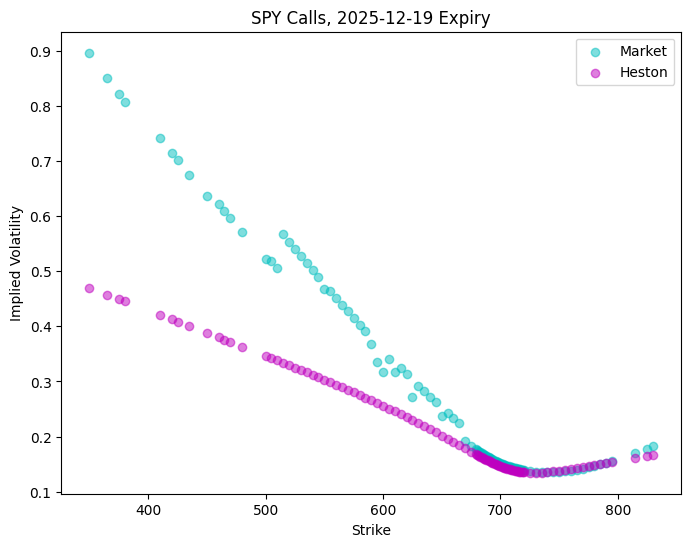

In [47]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(calls_single_exp['strike'], calls_single_exp['iv_mkt'], color = 'c', alpha = 0.5, label = 'Market')
ax.scatter(calls_single_exp['strike'], calls_single_exp['iv_heston'], color = 'm', alpha=0.5, label = 'Heston')
ax.set_xlabel("Strike")
ax.set_ylabel("Implied Volatility")
ax.set_title(f"{TICKER} Calls, {exp_date_str} Expiry")
plt.legend()
plt.show()

### Puts Only

In [45]:
single_exp_puts_list = build_vanilla_instruments(puts_single_exp, today)
puts_single_exp = bs_price_vega(puts_single_exp, single_exp_puts_list, S_quote, r_curve, q_curve)
puts_single_exp = calibration_weighting(puts_single_exp, LAMBDA_WING)

kappa, theta, sigma, rho, v0 = fit_heston_ls(puts_single_exp, single_exp_puts_list, S_quote, r_curve, q_curve)
fitted_model, calibrated_engine = make_engine(S_quote, r_curve, q_curve, kappa, theta, sigma, rho, v0)
rmse = rmse_price(puts_single_exp, single_exp_puts_list, calibrated_engine)
puts_single_exp = heston_iv(puts_single_exp, calibrated_engine, today, S_quote, r_curve, q_curve)

print("Calibrated Heston params:")
print(f"  kappa = {float(kappa):.8f}")
print(f"  theta = {float(theta):.8f}")
print(f"  sigma = {float(sigma):.8f}")
print(f"  rho   = {float(rho):.8f}")
print(f"  v0    = {float(v0):.8f}")
print(f"Price RMSE: {float(rmse):.8f} (Mean Option Price: {float(np.nanmean(puts_single_exp["mid"])):.8f})")

Calibrated Heston params:
  kappa = 4.03702665
  theta = 0.10980380
  sigma = 2.00000000
  rho   = -0.40661485
  v0    = 0.01279159
Price RMSE: 0.21750671 (Mean Option Price: 8.28876289)


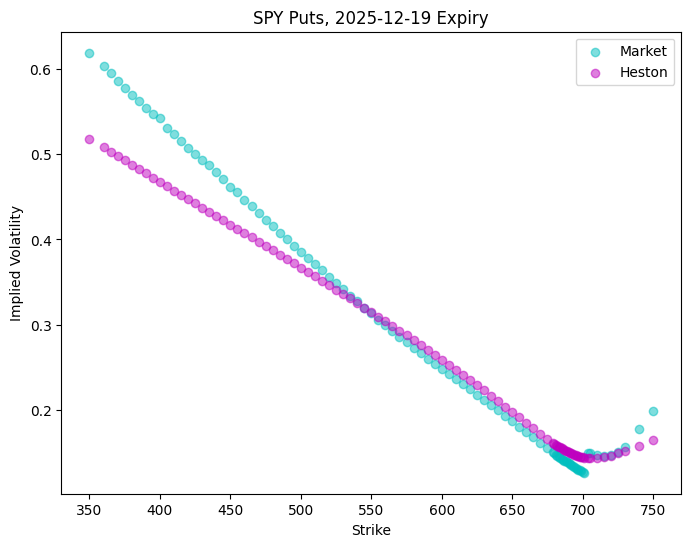

In [43]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(puts_single_exp['strike'], puts_single_exp['iv_mkt'], color = 'c', alpha = 0.5, label = 'Market')
ax.scatter(puts_single_exp['strike'], puts_single_exp['iv_heston'], color = 'm', alpha=0.5, label = 'Heston')
ax.set_xlabel("Strike")
ax.set_ylabel("Implied Volatility")
ax.set_title(f"{TICKER} Puts, {exp_date_str} Expiry")
plt.legend()
plt.show()

### All Options

In [48]:
single_exp_options_list = build_vanilla_instruments(chains_single_exp, today)
chains_single_exp = bs_price_vega(chains_single_exp, single_exp_options_list, S_quote, r_curve, q_curve)
chains_single_exp = calibration_weighting(chains_single_exp, LAMBDA_WING)

kappa, theta, sigma, rho, v0 = fit_heston_ls(chains_single_exp, single_exp_options_list, S_quote, r_curve, q_curve)
fitted_model, calibrated_engine = make_engine(S_quote, r_curve, q_curve, kappa, theta, sigma, rho, v0)
rmse = rmse_price(chains_single_exp, single_exp_options_list, calibrated_engine)
chains_single_exp = heston_iv(chains_single_exp, calibrated_engine, today, S_quote, r_curve, q_curve)

print("Calibrated Heston params:")
print(f"  kappa = {float(kappa):.8f}")
print(f"  theta = {float(theta):.8f}")
print(f"  sigma = {float(sigma):.8f}")
print(f"  rho   = {float(rho):.8f}")
print(f"  v0    = {float(v0):.8f}")
print(f"Price RMSE: {float(rmse):.8f} (Mean Option Price: {float(np.nanmean(chains_single_exp["mid"])):.8f})")

Calibrated Heston params:
  kappa = 15.00000000
  theta = 0.03153085
  sigma = 2.00000000
  rho   = -0.54864286
  v0    = 0.03494808
Price RMSE: 0.59273682 (Mean Option Price: 41.54640777)


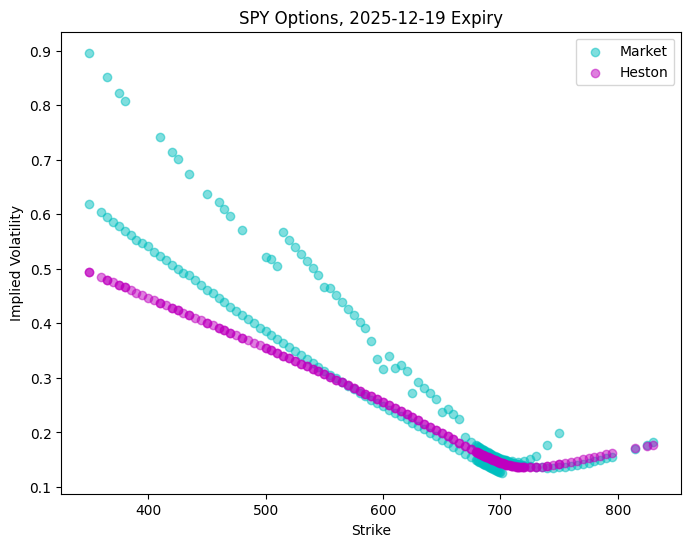

In [49]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(chains_single_exp['strike'], chains_single_exp['iv_mkt'], color = 'c', alpha = 0.5, label = 'Market')
ax.scatter(chains_single_exp['strike'], chains_single_exp['iv_heston'], color = 'm', alpha=0.5, label = 'Heston')
ax.set_xlabel("Strike")
ax.set_ylabel("Implied Volatility")
ax.set_title(f"{TICKER} Options, {exp_date_str} Expiry")
plt.legend()
plt.show()